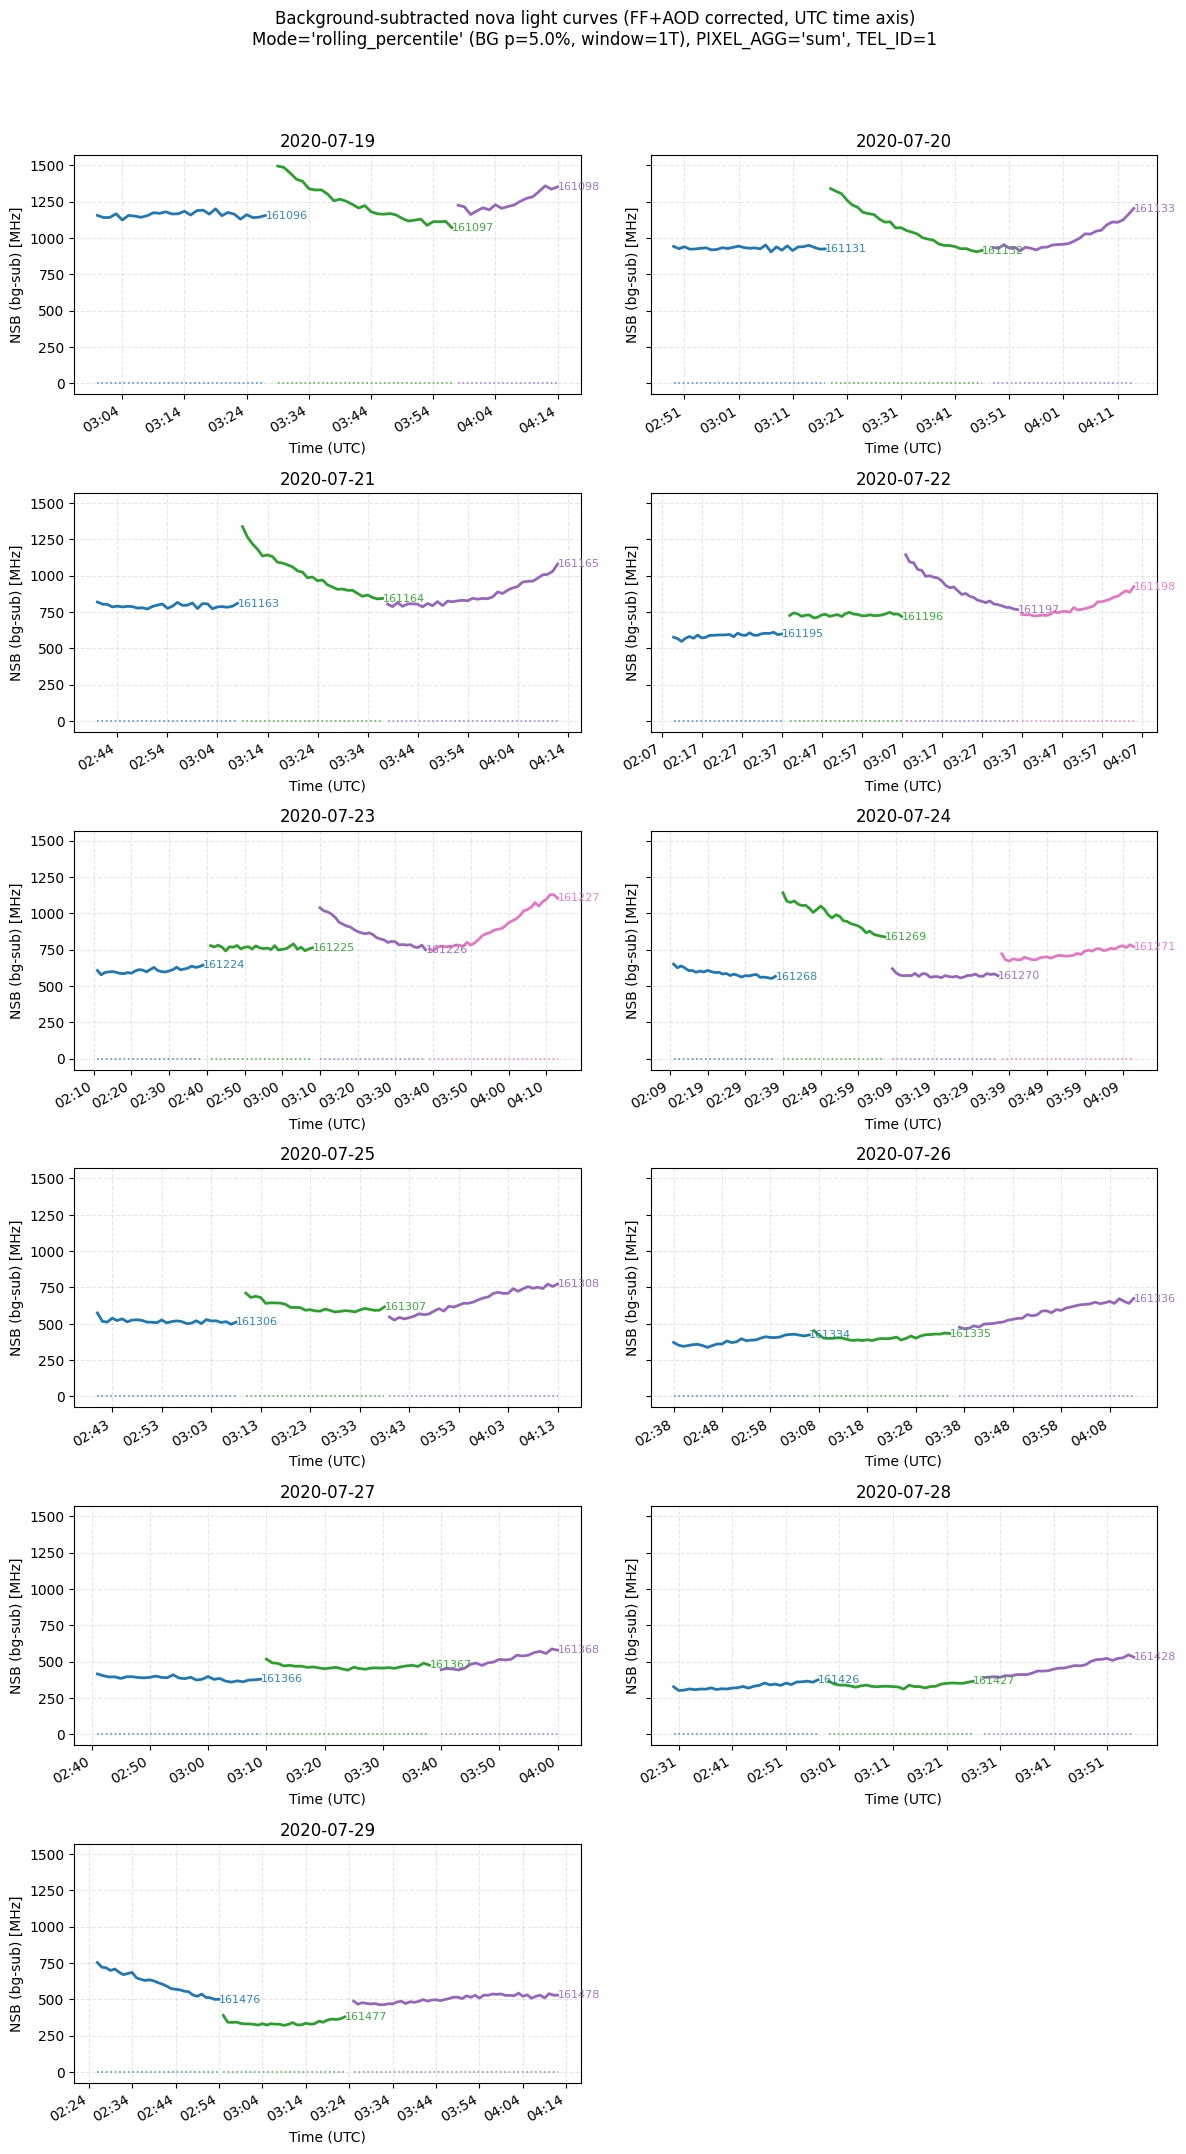

In [1]:
import json
import re
from pathlib import Path
from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ====================== CONFIG ======================

# --- which telescope / data ---
TEL_ID      = 1   # 1,2,3,4...
CORR_BASE   = f"/lfs/l7/hess/users/sghosh/projects/Satellite-trails/MGAB-V207/nsb_corrected/tel_{TEL_ID}"
NOVA_JSON   = f"/lfs/l7/hess/users/sghosh/projects/Satellite-trails/CT{TEL_ID}_all_runs/version_1.1/nova_config_CT{TEL_ID}.json"

# --- pixel aggregation ---
PIXEL_AGG   = "sum"      # "sum" or "mean"
BIN_INTERVAL = "1T"      # e.g. "10S", "30S", "1T" or None (keep native resolution)

# --- BG subtraction mode (pick one) ---
BG_SUB_MODE         = "rolling_percentile"   # "full" | "fraction" | "percentile" | "rolling_percentile"
BG_REMOVE_FRACTION  = 1.00                   # if mode == "fraction"; e.g. 0.90 removes 90% of background
BG_PERCENTILE       = 5.0                    # if mode == "percentile" (constant baseline = p-th percentile of BG)
ROLL_WINDOW         = "1T"                   # if mode == "rolling_percentile"
ROLL_PERCENTILE     = 5.0                    # if mode == "rolling_percentile"

# --- Plot layout & styling ---
NUM_COLS            = 2                      # number of columns in the day-grid figure
SAME_YLIM           = True                   # use common y-limits across all panels
Y_PAD               = 0.05                   # 5% padding of the global y-range when SAME_YLIM=True
ANNOTATE_RUN_IDS    = True                   # label each curve at its last point with the run id
FIGSIZE_PER_PANEL   = (6.0, 3.6)             # width x height of each day panel (inches)
SUPTITLE            = "Background-subtracted nova light curves (FF+AOD corrected, UTC time axis)"
PDF_OUT             = None                   # e.g. "bgsub_daywise_lightcurves_new.pdf" or None

# ====================================================


# ---------------- nova config loader ----------------
def load_nova_config(json_path: str) -> dict:
    """
    Load nova_config JSON: expects keys as run_ids (strings) and values
    containing at least 'pixels': [list of pixel IDs].
    """
    with open(json_path, "r") as f:
        cfg = json.load(f)
    out = {}
    for k, v in cfg.items():
        run_id = int(k)
        out[run_id] = v
    return out


# ---------------- helpers ----------------
def _discover_corr_files():
    """
    Discover corrected NSB files in CORR_BASE.
    Returns dict: run_id -> Path to corrected CSV.
    """
    base = Path(CORR_BASE)
    pattern = f"nsb_file_{TEL_ID}_*_ff_aod.csv"
    files = sorted(base.glob(pattern)) or sorted(base.rglob(pattern))
    run_files = {}

    for p in files:
        m = re.search(rf"nsb_file_{TEL_ID}_(\d+)_ff_aod\.csv$", p.name)
        if not m:
            continue
        run_id = int(m.group(1))
        run_files[run_id] = p

    return run_files


def _pixels_in_corr_file(corr_csv: Path) -> list:
    """Return all pixel IDs present in a corrected file."""
    df = pd.read_csv(corr_csv, sep=";", usecols=["Pixel"])
    return pd.unique(df["Pixel"]).tolist()


def _aggregate_corrected_series(corr_csv: Path,
                                pixel_ids,
                                bin_interval: str,
                                pixel_agg: str) -> pd.Series:
    """
    From a corrected per-pixel file (Time;Pixel;NSB_corr),
    build a 1D time series aggregating the given pixel_ids.
    """
    df = pd.read_csv(corr_csv, sep=";")
    df["Time"] = pd.to_datetime(df["Time"], utc=True, errors="coerce").dt.tz_convert(None)
    df = df.dropna(subset=["Time"])

    df = df[df["Pixel"].isin(pixel_ids)]
    if df.empty:
        return None

    df_wide = df.pivot(index="Time", columns="Pixel", values="NSB_corr").sort_index()

    if bin_interval:
        df_wide = df_wide.resample(bin_interval).mean()

    pixel_agg = (pixel_agg or "sum").lower()
    if pixel_agg == "sum":
        s = df_wide.sum(axis=1)
    elif pixel_agg == "mean":
        s = df_wide.mean(axis=1)
    else:
        raise ValueError(f"PIXEL_AGG='{pixel_agg}' not supported (use 'sum' or 'mean').")

    return s.dropna()


def _scale_background(bg_series: pd.Series, n_sig: int, n_bg: int, pixel_agg: str) -> pd.Series:
    """
    Match BG units to Signal units (handles PIXEL_AGG):
    - For 'sum': convert BG from mean-per-bg-pixel to sum-over-sig-pixels
    - For 'mean': BG already in per-pixel units -> no scaling.
    """
    if str(pixel_agg).lower() == "sum":
        return (bg_series / float(max(1, n_bg))) * float(max(1, n_sig))
    return bg_series  # 'mean' mode


def _apply_bg_subtraction(sig: pd.Series, bg_scaled: pd.Series) -> pd.Series:
    """Apply the chosen BG_SUB_MODE to produce a bg-subtracted series."""
    mode = str(BG_SUB_MODE).lower()
    if mode == "full":
        return (sig - bg_scaled).rename("sig_minus_bg")
    if mode == "fraction":
        return (sig - float(BG_REMOVE_FRACTION) * bg_scaled).rename("sig_minus_bg")
    if mode == "percentile":
        base = np.nanpercentile(bg_scaled.values, float(BG_PERCENTILE))
        return (sig - base).rename("sig_minus_bg")
    if mode == "rolling_percentile":
        bg_roll = bg_scaled.rolling(window=str(ROLL_WINDOW), center=True, min_periods=1)\
                           .quantile(float(ROLL_PERCENTILE) / 100.0)
        return (sig - bg_roll).rename("sig_minus_bg")
    raise ValueError(f"Unknown BG_SUB_MODE='{BG_SUB_MODE}'.")


def _distinct_colors(n, seed=42):
    import matplotlib.pyplot as plt
    base = []
    for cmap in ("tab10", "tab20", "tab20b", "tab20c"):
        cm = plt.get_cmap(cmap)
        base += [cm(i) for i in range(cm.N)]
    base = base[0::2] + base[1::2]
    if n <= len(base):
        return base[:n]
    hues = np.linspace(0, 1, n, endpoint=False)
    return [plt.cm.hsv(h) for h in hues]


# ---------------- build bg-subtracted series for ALL runs ----------------
nova_config = load_nova_config(NOVA_JSON)
run_files   = _discover_corr_files()

all_sub    = {}   # run_id -> bg-subtracted Series
run_dates  = {}   # run_id -> date
all_bgline = {}   # run_id -> BG line in subtracted space

for run_id, corr_csv in sorted(run_files.items()):
    # pixels from nova_config: these are the signal pixels
    sig_cfg = list(nova_config.get(run_id, {}).get("pixels", []))
    if not sig_cfg:
        continue

    # all pixels present in the corrected file
    all_pix = set(_pixels_in_corr_file(corr_csv))
    sig_pix = [p for p in sig_cfg if p in all_pix]
    bg_pix  = sorted(all_pix - set(sig_pix))

    if not sig_pix or not bg_pix:
        # need both signal and background pixels for BG subtraction
        continue

    # aggregated signal & background series from corrected data
    sig_corr = _aggregate_corrected_series(corr_csv, sig_pix, BIN_INTERVAL, PIXEL_AGG)
    bg_corr_raw = _aggregate_corrected_series(corr_csv, bg_pix, BIN_INTERVAL, PIXEL_AGG)

    if sig_corr is None or bg_corr_raw is None:
        continue

    # align time grid
    idx = sig_corr.index.intersection(bg_corr_raw.index)
    if len(idx) == 0:
        continue

    sig = sig_corr.reindex(idx)
    bg  = bg_corr_raw.reindex(idx)

    # scale BG to signal basis (for PIXEL_AGG='sum')
    bg_scaled = _scale_background(bg, n_sig=len(sig_pix), n_bg=len(bg_pix), pixel_agg=PIXEL_AGG)

    # apply chosen subtraction mode
    sub = _apply_bg_subtraction(sig, bg_scaled)
    if sub is None or sub.empty:
        continue

    # --- build a dotted BG line in the SAME space as 'sub' ---
    mode = BG_SUB_MODE.lower()
    if mode == "percentile":
        base = np.nanpercentile(bg_scaled.values, float(BG_PERCENTILE))
        bg_line_plot = (bg_scaled - base).rename("bg_line")           # residual bg wiggles
    elif mode == "rolling_percentile":
        bg_roll = bg_scaled.rolling(window=str(ROLL_WINDOW), center=True, min_periods=1)\
                           .quantile(float(ROLL_PERCENTILE) / 100.0)
        bg_line_plot = (bg_scaled - bg_roll).rename("bg_line")        # baseline removed
    elif mode in ("fraction", "full"):
        # Removed BG baseline is zero in subtracted space
        bg_line_plot = pd.Series(0.0, index=sub.index, name="bg_line")
    else:
        bg_line_plot = pd.Series(0.0, index=sub.index, name="bg_line")

    all_bgline[run_id] = bg_line_plot.reindex(sub.index)
    all_sub[run_id]    = sub
    run_dates[run_id]  = sub.index[0].date()

# ---------------- plotting ----------------
if not all_sub:
    print("No background-subtracted series were produced. Check nova_config, corrected files, and config.")
else:
    days = sorted(set(run_dates.values()))
    n_days = len(days)
    n_cols = int(NUM_COLS)
    n_rows = ceil(n_days / n_cols)
    fig_w = FIGSIZE_PER_PANEL[0] * n_cols
    fig_h = FIGSIZE_PER_PANEL[1] * n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False, sharey=SAME_YLIM)
    axes = axes.flatten()

    # Global y-limits (include BG lines too) if SAME_YLIM
    if SAME_YLIM:
        ymins, ymaxs = [], []
        for rid, s in all_sub.items():
            if len(s):
                ymins.append(np.nanmin(s.values))
                ymaxs.append(np.nanmax(s.values))
            b = all_bgline.get(rid)
            if b is not None and len(b):
                ymins.append(np.nanmin(b.values))
                ymaxs.append(np.nanmax(b.values))
        if ymins and ymaxs:
            y0, y1 = np.nanmin(ymins), np.nanmax(ymaxs)
            if str(BG_SUB_MODE).lower() in ("full", "fraction"):
                y0 = min(y0, 0.0)
                y1 = max(y1, 0.0)
            pad = (y1 - y0) * float(Y_PAD if (y1 > y0) else 0.05)
            global_ylim = (y0 - pad, y1 + pad)
        else:
            global_ylim = None
    else:
        global_ylim = None

    for di, day in enumerate(days):
        ax = axes[di]
        day_runs = sorted([rid for rid, d in run_dates.items() if d == day])
        colors = _distinct_colors(len(day_runs), seed=42)

        for rid, c in zip(day_runs, colors):
            s = all_sub[rid]

            # dotted BG baseline
            b = all_bgline.get(rid)
            if b is not None:
                b = b.reindex(s.index)
                ax.plot(b.index, b.values, ls=":", lw=1.2, color=c, alpha=0.8, zorder=1)

            # main signal curve
            ax.plot(s.index, s.values, lw=2.0, color=c, label=str(rid), zorder=2)

            if ANNOTATE_RUN_IDS and len(s) > 0:
                ax.text(s.index[-1], s.values[-1], f"{rid}",
                        fontsize=8, va="center", ha="left", color=c, alpha=0.9, zorder=3)

        ax.set_title(f"{day}")
        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("NSB (bg-sub) [MHz]")
        ax.grid(True, linestyle="--", alpha=0.3)
        if global_ylim:
            ax.set_ylim(*global_ylim)

    # hide unused subplots if grid not full
    for j in range(di + 1, len(axes)):
        axes[j].axis("off")

# NEW: format time-only x-axis
    for ax in axes:
        if not ax.has_data():
            continue
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_ha("right")


    extra_info = ""
    if BG_SUB_MODE == "percentile":
        extra_info = f" (BG p={BG_PERCENTILE}%)"
    elif BG_SUB_MODE == "rolling_percentile":
        extra_info = f" (BG p={ROLL_PERCENTILE}%, window={ROLL_WINDOW})"
    elif BG_SUB_MODE == "fraction":
        extra_info = f" (BGx{BG_REMOVE_FRACTION:.2f})"

    fig.suptitle(
        SUPTITLE
        + f"\nMode='{BG_SUB_MODE}'{extra_info}, PIXEL_AGG='{PIXEL_AGG}', TEL_ID={TEL_ID}",
        y=0.995
    )

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    if PDF_OUT:
        fig.savefig(PDF_OUT)
        print(f"Saved figure to {PDF_OUT}")

    plt.show()


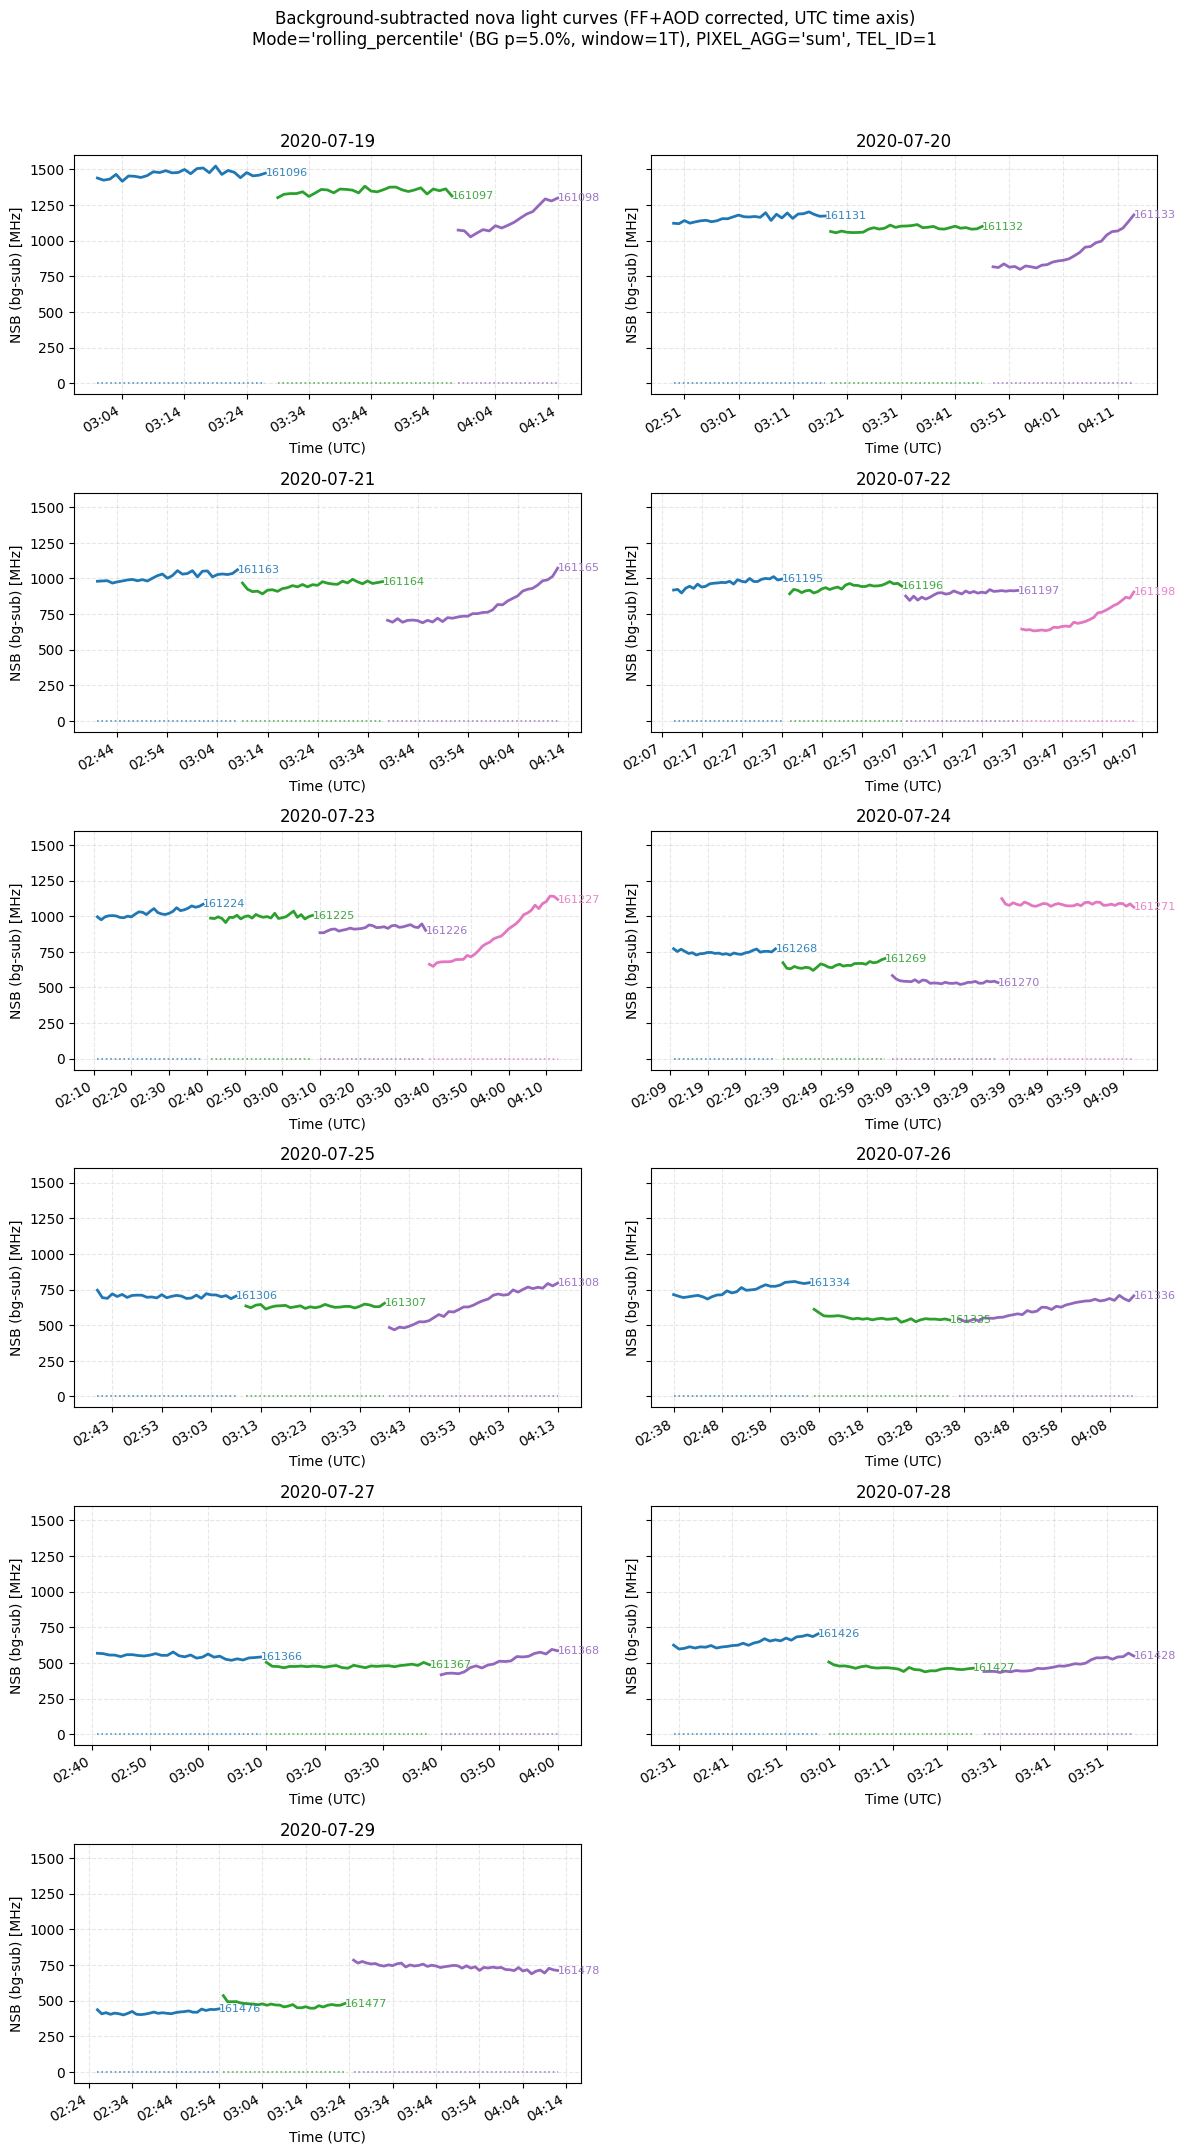

In [2]:
import json
import re
from pathlib import Path
from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ====================== CONFIG ======================

# --- which telescope / data ---
TEL_ID      = 1   # 1,2,3,4...
CORR_BASE   = f"/lfs/l7/hess/users/sghosh/projects/Satellite-trails/MGAB-V207/nsb_corrected/tel_{TEL_ID}"
NOVA_JSON   = f"/lfs/l7/hess/users/sghosh/projects/Satellite-trails/CT{TEL_ID}_all_runs/version_1.1/nova_config_CT{TEL_ID}.json"

# --- pixel aggregation ---
PIXEL_AGG   = "sum"      # "sum" or "mean"
BIN_INTERVAL = "1T"      # e.g. "10S", "30S", "1T" or None (keep native resolution)

# --- BG subtraction mode (pick one) ---
BG_SUB_MODE         = "rolling_percentile"   # "full" | "fraction" | "percentile" | "rolling_percentile"
BG_REMOVE_FRACTION  = 1.00                   # if mode == "fraction"; e.g. 0.90 removes 90% of background
BG_PERCENTILE       = 5.0                    # if mode == "percentile" (constant baseline = p-th percentile of BG)
ROLL_WINDOW         = "1T"                   # if mode == "rolling_percentile"
ROLL_PERCENTILE     = 5.0                    # if mode == "rolling_percentile"

# --- Plot layout & styling ---
NUM_COLS            = 2                      # number of columns in the day-grid figure
SAME_YLIM           = True                   # use common y-limits across all panels
Y_PAD               = 0.05                   # 5% padding of the global y-range when SAME_YLIM=True
ANNOTATE_RUN_IDS    = True                   # label each curve at its last point with the run id
FIGSIZE_PER_PANEL   = (6.0, 3.6)             # width x height of each day panel (inches)
SUPTITLE            = "Background-subtracted nova light curves (FF+AOD corrected, UTC time axis)"
PDF_OUT             = None                   # e.g. "bgsub_daywise_lightcurves_new.pdf" or None

# ====================================================


# ---------------- nova config loader ----------------
def load_nova_config(json_path: str) -> dict:
    """
    Load nova_config JSON: expects keys as run_ids (strings) and values
    containing at least 'pixels': [list of pixel IDs].
    """
    with open(json_path, "r") as f:
        cfg = json.load(f)
    out = {}
    for k, v in cfg.items():
        run_id = int(k)
        out[run_id] = v
    return out


# ---------------- helpers ----------------
def _discover_corr_files():
    """
    Discover corrected NSB files in CORR_BASE.
    Returns dict: run_id -> Path to corrected CSV.
    """
    base = Path(CORR_BASE)
    pattern = f"nsb_file_{TEL_ID}_*_ff_aod.csv"
    files = sorted(base.glob(pattern)) or sorted(base.rglob(pattern))
    run_files = {}

    for p in files:
        m = re.search(rf"nsb_file_{TEL_ID}_(\d+)_ff_aod\.csv$", p.name)
        if not m:
            continue
        run_id = int(m.group(1))
        run_files[run_id] = p

    return run_files


def _pixels_in_corr_file(corr_csv: Path) -> list:
    """Return all pixel IDs present in a corrected file."""
    df = pd.read_csv(corr_csv, sep=";", usecols=["Pixel"])
    return pd.unique(df["Pixel"]).tolist()


def _aggregate_corrected_series(corr_csv: Path,
                                pixel_ids,
                                bin_interval: str,
                                pixel_agg: str) -> pd.Series:
    """
    From a corrected per-pixel file (Time;Pixel;NSB_corr),
    build a 1D time series aggregating the given pixel_ids.
    """
    df = pd.read_csv(corr_csv, sep=";")
    df["Time"] = pd.to_datetime(df["Time"], utc=True, errors="coerce").dt.tz_convert(None)
    df = df.dropna(subset=["Time"])

    df = df[df["Pixel"].isin(pixel_ids)]
    if df.empty:
        return None

    df_wide = df.pivot(index="Time", columns="Pixel", values="NSB_corr").sort_index()

    if bin_interval:
        df_wide = df_wide.resample(bin_interval).mean()

    pixel_agg = (pixel_agg or "sum").lower()
    if pixel_agg == "sum":
        s = df_wide.sum(axis=1)
    elif pixel_agg == "mean":
        s = df_wide.mean(axis=1)
    else:
        raise ValueError(f"PIXEL_AGG='{pixel_agg}' not supported (use 'sum' or 'mean').")

    return s.dropna()


def _scale_background(bg_series: pd.Series, n_sig: int, n_bg: int, pixel_agg: str) -> pd.Series:
    """
    Match BG units to Signal units (handles PIXEL_AGG):
    - For 'sum': convert BG from mean-per-bg-pixel to sum-over-sig-pixels
    - For 'mean': BG already in per-pixel units -> no scaling.
    """
    if str(pixel_agg).lower() == "sum":
        return (bg_series / float(max(1, n_bg))) * float(max(1, n_sig))
    return bg_series  # 'mean' mode


def _apply_bg_subtraction(sig: pd.Series, bg_scaled: pd.Series) -> pd.Series:
    """Apply the chosen BG_SUB_MODE to produce a bg-subtracted series."""
    mode = str(BG_SUB_MODE).lower()
    if mode == "full":
        return (sig - bg_scaled).rename("sig_minus_bg")
    if mode == "fraction":
        return (sig - float(BG_REMOVE_FRACTION) * bg_scaled).rename("sig_minus_bg")
    if mode == "percentile":
        base = np.nanpercentile(bg_scaled.values, float(BG_PERCENTILE))
        return (sig - base).rename("sig_minus_bg")
    if mode == "rolling_percentile":
        bg_roll = bg_scaled.rolling(window=str(ROLL_WINDOW), center=True, min_periods=1)\
                           .quantile(float(ROLL_PERCENTILE) / 100.0)
        return (sig - bg_roll).rename("sig_minus_bg")
    raise ValueError(f"Unknown BG_SUB_MODE='{BG_SUB_MODE}'.")


def _distinct_colors(n, seed=42):
    import matplotlib.pyplot as plt
    base = []
    for cmap in ("tab10", "tab20", "tab20b", "tab20c"):
        cm = plt.get_cmap(cmap)
        base += [cm(i) for i in range(cm.N)]
    base = base[0::2] + base[1::2]
    if n <= len(base):
        return base[:n]
    hues = np.linspace(0, 1, n, endpoint=False)
    return [plt.cm.hsv(h) for h in hues]


# ---------------- build bg-subtracted series for ALL runs ----------------
nova_config = load_nova_config(NOVA_JSON)
run_files   = _discover_corr_files()

all_sub    = {}   # run_id -> bg-subtracted Series
run_dates  = {}   # run_id -> date
all_bgline = {}   # run_id -> BG line in subtracted space

for run_id, corr_csv in sorted(run_files.items()):
    # pixels from nova_config: these are the signal pixels
    sig_cfg = list(nova_config.get(run_id, {}).get("pixels", []))
    if not sig_cfg:
        continue

    # all pixels present in the corrected file
    all_pix = set(_pixels_in_corr_file(corr_csv))
    sig_pix = [p for p in sig_cfg if p in all_pix]
    bg_pix  = sorted(all_pix - set(sig_pix))

    if not sig_pix or not bg_pix:
        # need both signal and background pixels for BG subtraction
        continue

    # aggregated signal & background series from corrected data
    sig_corr = _aggregate_corrected_series(corr_csv, sig_pix, BIN_INTERVAL, PIXEL_AGG)
    bg_corr_raw = _aggregate_corrected_series(corr_csv, bg_pix, BIN_INTERVAL, PIXEL_AGG)

    if sig_corr is None or bg_corr_raw is None:
        continue

    # align time grid
    idx = sig_corr.index.intersection(bg_corr_raw.index)
    if len(idx) == 0:
        continue

    sig = sig_corr.reindex(idx)
    bg  = bg_corr_raw.reindex(idx)

    # scale BG to signal basis (for PIXEL_AGG='sum')
    bg_scaled = _scale_background(bg, n_sig=len(sig_pix), n_bg=len(bg_pix), pixel_agg=PIXEL_AGG)

    # apply chosen subtraction mode
    sub = _apply_bg_subtraction(sig, bg_scaled)
    if sub is None or sub.empty:
        continue

    # --- build a dotted BG line in the SAME space as 'sub' ---
    mode = BG_SUB_MODE.lower()
    if mode == "percentile":
        base = np.nanpercentile(bg_scaled.values, float(BG_PERCENTILE))
        bg_line_plot = (bg_scaled - base).rename("bg_line")           # residual bg wiggles
    elif mode == "rolling_percentile":
        bg_roll = bg_scaled.rolling(window=str(ROLL_WINDOW), center=True, min_periods=1)\
                           .quantile(float(ROLL_PERCENTILE) / 100.0)
        bg_line_plot = (bg_scaled - bg_roll).rename("bg_line")        # baseline removed
    elif mode in ("fraction", "full"):
        # Removed BG baseline is zero in subtracted space
        bg_line_plot = pd.Series(0.0, index=sub.index, name="bg_line")
    else:
        bg_line_plot = pd.Series(0.0, index=sub.index, name="bg_line")

    all_bgline[run_id] = bg_line_plot.reindex(sub.index)
    all_sub[run_id]    = sub
    run_dates[run_id]  = sub.index[0].date()

# ---------------- plotting ----------------
if not all_sub:
    print("No background-subtracted series were produced. Check nova_config, corrected files, and config.")
else:
    days = sorted(set(run_dates.values()))
    n_days = len(days)
    n_cols = int(NUM_COLS)
    n_rows = ceil(n_days / n_cols)
    fig_w = FIGSIZE_PER_PANEL[0] * n_cols
    fig_h = FIGSIZE_PER_PANEL[1] * n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False, sharey=SAME_YLIM)
    axes = axes.flatten()

    # Global y-limits (include BG lines too) if SAME_YLIM
    if SAME_YLIM:
        ymins, ymaxs = [], []
        for rid, s in all_sub.items():
            if len(s):
                ymins.append(np.nanmin(s.values))
                ymaxs.append(np.nanmax(s.values))
            b = all_bgline.get(rid)
            if b is not None and len(b):
                ymins.append(np.nanmin(b.values))
                ymaxs.append(np.nanmax(b.values))
        if ymins and ymaxs:
            y0, y1 = np.nanmin(ymins), np.nanmax(ymaxs)
            if str(BG_SUB_MODE).lower() in ("full", "fraction"):
                y0 = min(y0, 0.0)
                y1 = max(y1, 0.0)
            pad = (y1 - y0) * float(Y_PAD if (y1 > y0) else 0.05)
            global_ylim = (y0 - pad, y1 + pad)
        else:
            global_ylim = None
    else:
        global_ylim = None

    for di, day in enumerate(days):
        ax = axes[di]
        day_runs = sorted([rid for rid, d in run_dates.items() if d == day])
        colors = _distinct_colors(len(day_runs), seed=42)

        for rid, c in zip(day_runs, colors):
            s = all_sub[rid]

            # dotted BG baseline
            b = all_bgline.get(rid)
            if b is not None:
                b = b.reindex(s.index)
                ax.plot(b.index, b.values, ls=":", lw=1.2, color=c, alpha=0.8, zorder=1)

            # main signal curve
            ax.plot(s.index, s.values, lw=2.0, color=c, label=str(rid), zorder=2)

            if ANNOTATE_RUN_IDS and len(s) > 0:
                ax.text(s.index[-1], s.values[-1], f"{rid}",
                        fontsize=8, va="center", ha="left", color=c, alpha=0.9, zorder=3)

        ax.set_title(f"{day}")
        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("NSB (bg-sub) [MHz]")
        ax.grid(True, linestyle="--", alpha=0.3)
        if global_ylim:
            ax.set_ylim(*global_ylim)

    # hide unused subplots if grid not full
    for j in range(di + 1, len(axes)):
        axes[j].axis("off")

# NEW: format time-only x-axis
    for ax in axes:
        if not ax.has_data():
            continue
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_ha("right")


    extra_info = ""
    if BG_SUB_MODE == "percentile":
        extra_info = f" (BG p={BG_PERCENTILE}%)"
    elif BG_SUB_MODE == "rolling_percentile":
        extra_info = f" (BG p={ROLL_PERCENTILE}%, window={ROLL_WINDOW})"
    elif BG_SUB_MODE == "fraction":
        extra_info = f" (BGx{BG_REMOVE_FRACTION:.2f})"

    fig.suptitle(
        SUPTITLE
        + f"\nMode='{BG_SUB_MODE}'{extra_info}, PIXEL_AGG='{PIXEL_AGG}', TEL_ID={TEL_ID}",
        y=0.995
    )

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    if PDF_OUT:
        fig.savefig(PDF_OUT)
        print(f"Saved figure to {PDF_OUT}")

    plt.show()
